## Vector Search

See vector embedding and evaluation script.

In [1]:
# Load the results for the evaluation
import bz2
import _pickle as pickle
# results with timout 200
vector_results = pickle.load(bz2.BZ2File('vector_results_script.pkl.bz2', 'rb'))
eval_queries = pickle.load(bz2.BZ2File('eval_queries.pkl.bz2', 'rb'))

In [2]:
vector_results

,id,retrieved,query_time
0,0,"[<dbpedia:Cuisine_of_Szechwan>, <dbpedia:Szech...",0.373965
1,1,"[<dbpedia:Ancient_Roman_architecture>, <dbpedi...",0.616197
2,2,"[<dbpedia:Sisu_SA-240>, <dbpedia:Sisu_Auto>, <...",0.117644
3,3,"[<dbpedia:Bombing_of_Normandy>, <dbpedia:Invas...",0.095147
4,4,"[<dbpedia:Group_Selection>, <dbpedia:List_of_s...",0.123194
...,...,...,...
462,462,[<dbpedia:List_of_professional_sports_teams_in...,0.047004
463,463,"[<dbpedia:GlobeImmune>, <dbpedia:MedImmune>, <...",0.049078
464,464,[<dbpedia:List_of_Nobel_laureates_affiliated_w...,0.048354
465,465,"[<dbpedia:US_Airways_fleet>, <dbpedia:Boeing_7...",0.048856


In [4]:
#  average query time
from scipy import stats
import numpy as np
querytimes = vector_results['query_time']
mean_query_time = np.mean(querytimes)
median_query_time = np.median(vector_results['query_time'])
mode_query_time = stats.mode(round(vector_results['query_time'], 4))
print(f'Mean query times: {round(mean_query_time, 4)} seconds\nMedian query times: {round(median_query_time, 4)} seconds\nMode query times when query times rounded to 1 decimal: {str(mode_query_time.mode)} appeared {str(mode_query_time.count)} times')

Mean query times: 0.0974 seconds
Median query times: 0.0561 seconds
Mode query times when query times rounded to 1 decimal: [0.0444] appeared [7] times


In [5]:
display(querytimes.nlargest(10), querytimes.nsmallest(10))

145    1.870706
143    1.805792
144    1.696234
148    1.665734
147    1.508186
181    1.074604
142    0.826082
1      0.616197
461    0.570484
100    0.529658
Name: query_time, dtype: float64

35     0.037922
60     0.037958
348    0.038323
59     0.038538
57     0.039798
331    0.040788
341    0.040869
362    0.041069
315    0.041295
353    0.041305
Name: query_time, dtype: float64

Text(0.5, 0, 'Query Time')

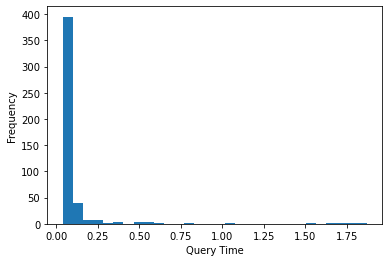

In [47]:
import matplotlib.pyplot as plt
# frequency of query times
vector_results['query_time'].plot.hist(bins=30);
plt.xlabel('Query Time')


In [9]:
# all needed data for evaluation
ids = vector_results['id']
evaluated_queries = [eval_queries['query'][id] for id in ids]
relevant_entities = [eval_queries['relevant_entities'][id] for id in ids]
very_relevant_entities = [eval_queries['very_relevant_entities'][id] for id in ids]
retrieved_entities = vector_results['retrieved']

In [10]:
len_eval_queries = [len(query.split()) for query in evaluated_queries]

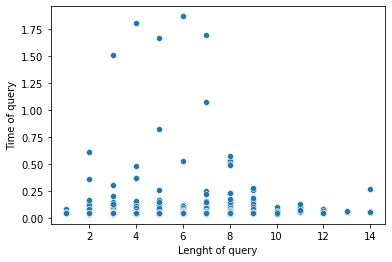

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

# plot query time with query lenghts
sns.scatterplot(y =querytimes, x = len_eval_queries);
plt.xlabel('Lenght of query');
plt.ylabel('Time of query');

### Precision Recall @n

In [12]:
assesed_retrieved_precision_recall = []
len_relevants = []
assesed_retrieved_nDCG = []

for retrievedentities, relevantentities, veryrelevantentities in zip(retrieved_entities, relevant_entities, very_relevant_entities):
    assesed_precision_recall = []
    assesed_nDCG = []

    for entity in retrievedentities:
        if entity in relevantentities:
            assesed_precision_recall.append(1)
            assesed_nDCG.append(1)

        if entity in veryrelevantentities:
            assesed_precision_recall.append(1)
            assesed_nDCG.append(2)

        else:
            assesed_precision_recall.append(0)
            assesed_nDCG.append(0)
    
    len_relevants.append(len(relevantentities) + len(veryrelevantentities))

    assesed_retrieved_precision_recall.append(assesed_precision_recall)
    assesed_retrieved_nDCG.append(assesed_nDCG)

In [39]:
# precision at n micro macro average
import numpy as np

def micro_macro_precision_recall_at_n(score_list:list, number_of_relevant_entities:list, n):
    total_relevant = 0
    total_number_retrieved = 0
    precision_scores = []
    recall_scores = []

    for scores, number_relevant in zip(score_list, number_of_relevant_entities):
        if len(scores) < n :
            continue
        
        scores = scores[:n]
        relevant = sum(scores)
        number_retrieved = len(scores)
        precision = relevant/number_retrieved
        recall = relevant/number_relevant


        precision_scores.append(precision)
        recall_scores.append(recall)
        total_relevant += relevant
        total_number_retrieved += number_retrieved

    if total_relevant == 0:
        micro_average_precision = 0
        macro_average_precision = 0

        micro_average_recall = 0
        macro_average_recall = 0
    else:
        micro_average_precision = total_relevant/total_number_retrieved
        macro_average_precision = np.mean(precision_scores)

        micro_average_recall = total_relevant/sum(number_of_relevant_entities)
        macro_average_recall = np.mean(recall_scores)

    return micro_average_precision, macro_average_precision, micro_average_recall, macro_average_recall

# PLOT PRECISION AT N RECALL AT N Take the scores over the length of the scores

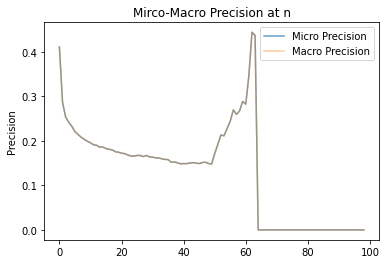

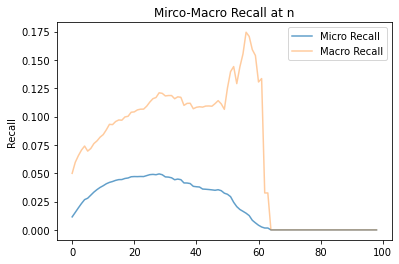

In [40]:
import matplotlib.pyplot as plt
micro_p = []
macro_p = []
micro_r = []
macro_r = []

for n in range(1, 100):
    micro_average_precision, macro_average_precision, micro_average_recall, macro_average_recall = micro_macro_precision_recall_at_n(assesed_retrieved_precision_recall, len_relevants, n)
    micro_p.append(micro_average_precision)
    macro_p.append(macro_average_precision)
    micro_r.append(micro_average_recall)
    macro_r.append(macro_average_recall)

plt.plot(micro_p, alpha=0.7, label='Micro Precision');
plt.title('Mirco-Macro Precision at n')
plt.ylabel('Precision')
plt.plot(macro_p, alpha=0.4, label='Macro Precision');
plt.legend()
# plt.title('Marco Precision at n')
# plt.ylabel('Precision')
plt.show();
plt.plot(micro_r, alpha=0.7, label='Micro Recall');
plt.title('Mirco-Macro Recall at n')
plt.ylabel('Recall')
plt.plot(macro_r, alpha=0.4, label='Macro Recall');
plt.legend()


In [41]:
total_relevant = 0
total_number_retrieved = 0
precision_scores = []
recall_scores = []

for id, (scores, number_relevant) in enumerate(zip(assesed_retrieved_precision_recall, len_relevants)):
    relevant = sum(scores)
    number_retrieved = len(scores)
    precision = relevant/number_retrieved
    recall = relevant/number_relevant


    precision_scores.append(precision)
    recall_scores.append(recall)
    total_relevant += relevant
    total_number_retrieved += number_retrieved

micro_average_precision = total_relevant/total_number_retrieved
macro_average_precision = np.mean(precision_scores)

micro_average_recall = total_relevant/sum(len_relevants)
macro_average_recall = np.mean(recall_scores)

print(f'The Global Precision:\nMicro Average: {micro_average_precision}\nMacro Average: {macro_average_precision}\n')
print(f'The Global Recall:\nMicro Average: {micro_average_recall}\nMacro Average: {macro_average_recall}')

The Global Precision:
Micro Average: 0.14398660589712584
Macro Average: 0.14180312180037297

The Global Recall:
Micro Average: 0.09269461077844311
Macro Average: 0.15726926074517902


### DCG, iDCG, nDCG @n

In [42]:
import numpy as np

def dcg_idcg_ndcg(retrieved_relevance_DCG_scores:list, n:int):
    # Relevance scores in Ideal order
    sorted_relevace = sorted(retrieved_relevance_DCG_scores[:n], reverse=True)
    # Relevance scores in output order
    relevance_score = retrieved_relevance_DCG_scores[:n]

    def discountedCumulativeGain(result):
        dcg = []
        for idx, val in enumerate(result): 
            numerator = 2**val - 1
            # add 2 because python 0-index
            denominator =  np.log2(idx + 2) 
            score = numerator/denominator
            dcg.append(score)
        return sum(dcg)

    def normalizedDiscountedCumulativeGain(result, sorted_result): 
        dcg = discountedCumulativeGain(result)
        idcg = discountedCumulativeGain(sorted_result)
        ndcg = dcg / idcg
        return ndcg

    
    return discountedCumulativeGain(relevance_score), discountedCumulativeGain(sorted_relevace), normalizedDiscountedCumulativeGain(relevance_score, sorted_relevace)

In [43]:
import numpy as np

mean_dcg_at_n, mean_idcg_at_n, mean_ndcg_at_n, mean_skipped_at_n = [], [], [], []

for n in range(1, 100):
    dcg_at_n, idcg_at_n, ndcg_at_n, skipped = [], [], [], 0
    
    for scores in assesed_retrieved_nDCG:
        if len(scores)< n:
            skipped += 1
            continue
        dcg, ideal_dcg, ndcg  = dcg_idcg_ndcg(scores, n)[0], dcg_idcg_ndcg(scores, n)[1], dcg_idcg_ndcg(scores, n)[2]
        dcg_at_n.append(dcg)
        idcg_at_n.append(ideal_dcg)
        ndcg_at_n.append(ndcg)


    mean_dcg_at_n.append(np.mean(dcg_at_n))
    mean_idcg_at_n.append(np.mean(dcg_at_n))
    mean_ndcg_at_n.append(np.mean(dcg_at_n))
    mean_skipped_at_n.append(skipped/len(assesed_retrieved_nDCG)*100)

    

/var/folders/wt/zc3p8xys6pzdscmtyvwvlrkc0000gn/T/ipykernel_52866/473647459.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ndcg = dcg / idcg


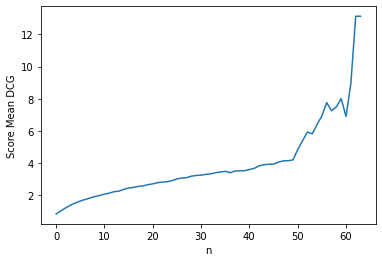

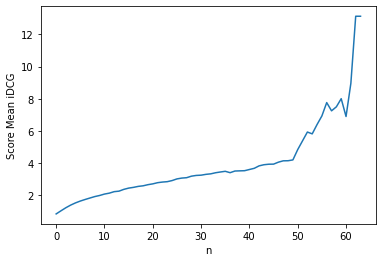

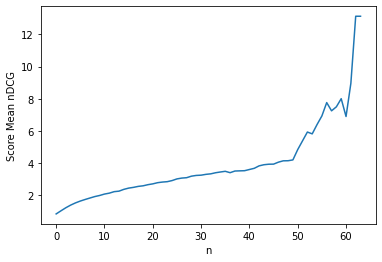

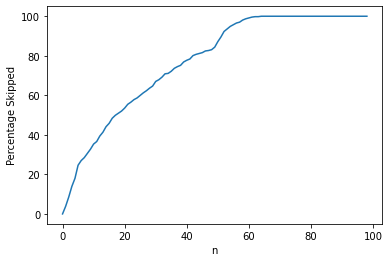

In [44]:
import matplotlib.pyplot as plt

plt.plot(mean_dcg_at_n)
plt.ylabel('Score Mean DCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_idcg_at_n)
plt.ylabel('Score Mean iDCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_ndcg_at_n)
plt.ylabel('Score Mean nDCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_skipped_at_n)
plt.ylabel('Percentage Skipped')
plt.xlabel('n')
plt.show()


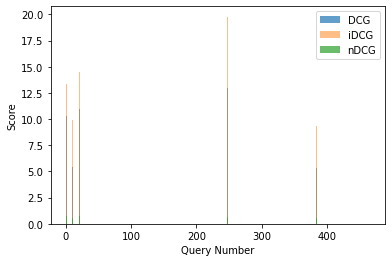

In [36]:
n = 59
dcg_at_n, idcg_at_n, ndcg_at_n = [], [], []
show_dense = False

for i in assesed_retrieved_nDCG:
    scores = i[:n]
    if (len(scores)< n) and show_dense: continue
    if len(scores)< n:
        dcg_at_n.append(0)
        idcg_at_n.append(0)
        ndcg_at_n.append(0)
        continue
    dcg, ideal_dcg, ndcg  = dcg_idcg_ndcg(scores, n)[0], dcg_idcg_ndcg(scores, n)[1], dcg_idcg_ndcg(scores, n)[2]
    dcg_at_n.append(dcg)
    idcg_at_n.append(ideal_dcg)
    ndcg_at_n.append(ndcg)

plt.bar(range(len(dcg_at_n)), dcg_at_n, label='DCG', alpha=0.7)
plt.bar(range(len(idcg_at_n)),idcg_at_n, label="iDCG", alpha=0.5)
plt.bar(range(len(ndcg_at_n)),ndcg_at_n, label='nDCG', alpha=0.7)
plt.ylabel('Score')
plt.xlabel('Query Number')
plt.legend()
plt.show()